In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *

In [3]:
PATH = "../datasets/yeast_v4.1"
data_path = Path(PATH)

In [4]:
CLASSES = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200

In [5]:
stats_name = "yeast_v4_per_class.dict"
test_dirs, train_dirs = dataset_source(data_path)
stats_dict = Statistics.per_class(test_dirs, train_dirs,save_name=stats_name)

working on: Cit1_MC_mfb1KO
working on: Cit1_MC_WT
working on: Cit1_MC_mmr1KO
working on: Cit1_MC_mfb1KO_mmr1KO


In [6]:
def get_data(path: str, sz, bs, stats):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='test', bs=bs)
    stats_dict = {lbl2index[key]: val for key, val in stats.items()}
    tfms = tfms_from_stats(stats_dict, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [7]:
data = get_data(PATH,SIZE, BATCH_SIZE,stats_dict)


 class to index mapping:
 {'Cit1_MC_WT': 0, 'Cit1_MC_mfb1KO': 1, 'Cit1_MC_mfb1KO_mmr1KO': 2, 'Cit1_MC_mmr1KO': 3}


In [8]:
x, y = next(iter(data.trn_dl))

In [9]:
print(y.size())

torch.Size([64])


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


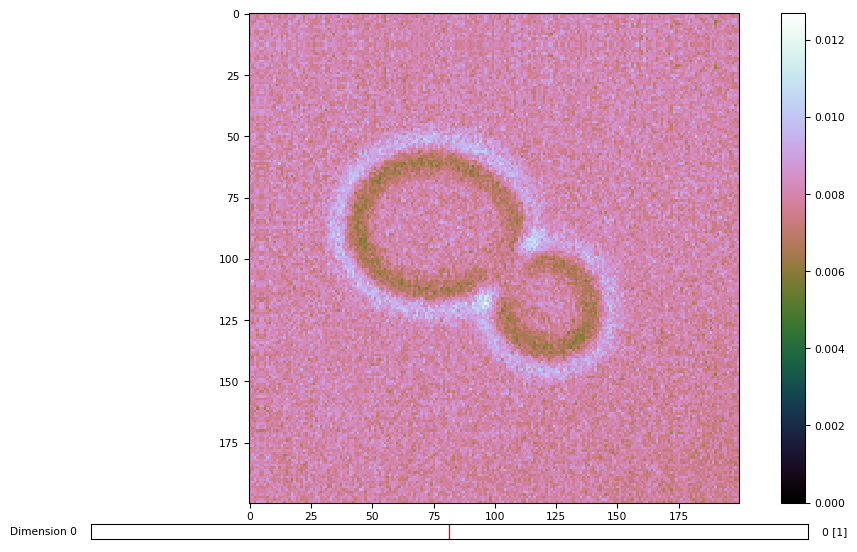

In [38]:
idx = 30
tiff.imshow(data.trn_ds.denorm(x[idx], y[idx].item()).squeeze()[:,:,0]); #denorm function called has a rollaxis() hence indexing changes.

# Training setup

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(SimpleNet([200*200*2, 40, NUM_CLASSES]), data) #(!) change channel-number & classes accordingly

In [ ]:
learn, [o.numel() for o in learn.model.parameters()]

In [ ]:
learn.summary()

In [ ]:
lr=1e-5

In [ ]:
%time learn.fit(lr, 200, cycle_len=1)

## ConvNet

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=5, stride=1, padding=(2,2))
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(ConvNet([2, 20, 40, 80], 4), data)

In [ ]:
learn.summary() ### learner.summary is hardcording the number of channels = 3

In [ ]:
lr=1e-10

In [ ]:
%time learn.fit(lr, 10, cycle_len=1)

In [ ]:
torch.cuda.is_available()

## ResNet_with_Batchnorm

In [9]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [10]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [11]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [12]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 4), data)

In [13]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 200, 200]),
                           ('output_shape', [-1, 10, 200, 200]),
                           ('trainable', True),
                           ('nb_params', 510)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 100, 100]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 3600)])),
             ('ResnetLayer-5',
     

In [14]:
wd=1e-5

In [16]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

[0]:  0.0%                                              
[1]:  0.0%
[2]:  0.0%
[3]:  1.0%
epoch      trn_loss   val_loss   accuracy   
    0      25.581697  30.493193  0.25      
[0]:  0.0%                                              
[1]: 0.5714%
[2]:  0.0%
[3]: 0.2571%
    1      18.428903  3.97645    0.157143  
[0]: 0.6571%                                            
[1]:  0.0%
[2]:  0.0%
[3]: 0.6286%
    2      12.323148  2.583577   0.271429  
[0]: 0.7143%                                            
[1]:  0.0%
[2]:  0.0%
[3]:  0.6%
    3      9.038193   2.245134   0.271429  
[0]:  0.0%                                              
[1]:  0.0%
[2]:  0.0%
[3]:  1.0%
    4      7.880948   3.536949   0.25      
[0]: 0.5429%                                            
[1]:  0.0%
[2]:  0.0%
[3]: 0.7429%
    5      6.712053   3.525544   0.307143  
[0]:  0.0%                                              
[1]: 0.02857%
[2]:  0.0%
[3]: 0.9714%
    6      5.612187   1.736191   0.242857  
[0]:

[array([1.2065]), 0.42142857228006636]

In [17]:
# at very little overfitting we have 43% accuracy
%time learn.fit(1e-2, 8, wds=wd, cycle_len=10, use_clr=(20,8, 0.95, 0.85), best_save_name='Objective_A_Resnet_per_class_1')

[0]: 0.7143%                                            
[1]: 0.7429%
[2]:  0.0%
[3]: 0.2571%
epoch      trn_loss   val_loss   accuracy   
    0      1.105697   1.193817   0.457143  
[0]:  0.6%                                              
[1]: 0.5143%
[2]: 0.3143%
[3]:  0.4%
    1      1.094214   1.135195   0.464286  
[0]:  0.6%                                              
[1]: 0.7429%
[2]: 0.02857%
[3]: 0.4571%
    2      1.091948   1.171005   0.457143  
[0]:  0.8%                                              
[1]:  0.6%
[2]:  0.0%
[3]: 0.4857%
    3      1.087722   1.183474   0.478571  
[0]: 0.6857%                                            
[1]: 0.6571%
[2]: 0.1714%
[3]:  0.4%
    4      1.071783   1.106331   0.478571  
[0]: 0.7429%                                            
[1]:  0.6%
[2]:  0.0%
[3]: 0.5143%
    5      1.065074   1.132733   0.492857  
[0]: 0.7143%                                            
[1]: 0.5143%
[2]:  0.0%
[3]: 0.6286%
    6      1.054835   1.143252   0

    58     0.675869   0.916484   0.657143  
[0]: 0.6857%                                             
[1]: 0.8571%
[2]: 0.1143%
[3]:  0.8%
    59     0.662394   0.846393   0.678571  
[0]:  0.8%                                               
[1]: 0.6857%
[2]: 0.1143%
[3]:  0.8%
    60     0.658014   0.896845   0.628571  
[0]: 0.9143%                                             
[1]:  0.8%
[2]: 0.1714%
[3]:  0.6%
    61     0.644373   1.013676   0.621429  
[0]: 0.8286%                                             
[1]:  0.6%
[2]: 0.2571%
[3]: 0.7143%
    62     0.651158   0.905012   0.628571  
[0]:  0.8%                                               
[1]: 0.7143%
[2]: 0.2286%
[3]: 0.7429%
    63     0.660707   0.830163   0.657143  
[0]: 0.7143%                                             
[1]: 0.4571%
[2]: 0.2857%
[3]: 0.8571%
    64     0.667207   0.992508   0.621429  
[0]: 0.7429%                                             
[1]: 0.8571%
[2]: 0.1714%
[3]: 0.6571%
    65     0.656517   0

[array([0.80839]), 0.6714285714285714]

In [18]:
%time learn.fit(1e-3, 8, wds=wd, cycle_len=20, use_clr=(20,8, 0.95, 0.85), best_save_name='Objective_A_Resnet_per_class_2')

[0]: 0.7714%                                             
[1]: 0.8286%
[2]: 0.1714%
[3]: 0.7714%
epoch      trn_loss   val_loss   accuracy   
    0      0.480705   0.785437   0.7       
[0]: 0.7714%                                             
[1]: 0.8571%
[2]: 0.2286%
[3]: 0.7714%
    1      0.478187   0.75729    0.728571  
[0]:  0.8%                                               
[1]:  0.8%
[2]: 0.1714%
[3]: 0.7143%
    2      0.482345   0.802023   0.685714  
[0]: 0.7714%                                             
[1]: 0.8286%
[2]: 0.1429%
[3]: 0.7429%
    3      0.478116   0.788046   0.692857  
[0]: 0.7429%                                             
[1]:  0.8%
[2]:  0.2%
[3]: 0.7714%
    4      0.468736   0.776927   0.707143  
[0]:  0.8%                                               
[1]: 0.8571%
[2]: 0.1714%
[3]: 0.7429%
    5      0.467146   0.789682   0.707143  
[0]: 0.7429%                                             
[1]: 0.8571%
[2]: 0.1714%
[3]: 0.7714%
    6      0.46611

    58     0.432166   0.77689    0.728571  
[0]:  0.8%                                               
[1]: 0.8286%
[2]: 0.1714%
[3]: 0.7714%
    59     0.430623   0.77896    0.728571  
[0]: 0.7714%                                             
[1]: 0.8286%
[2]: 0.2571%
[3]: 0.7143%
    60     0.430427   0.756697   0.707143  
[0]: 0.7714%                                             
[1]: 0.8857%
[2]: 0.2286%
[3]: 0.7143%
    61     0.428124   0.763286   0.714286  
[0]:  0.8%                                               
[1]: 0.7714%
[2]: 0.1429%
[3]: 0.7714%
    62     0.430638   0.79151    0.685714  
[0]: 0.7714%                                             
[1]:  0.8%
[2]: 0.2857%
[3]: 0.7714%
    63     0.429523   0.734173   0.735714  
[0]:  0.8%                                               
[1]: 0.8286%
[2]:  0.2%
[3]: 0.7714%
    64     0.425523   0.766349   0.721429  
[0]: 0.7714%                                             
[1]: 0.8571%
[2]: 0.2857%
[3]: 0.7429%
    65     0.4271

[array([0.78974]), 0.7]

In [15]:
learn.load('Objective_A_Resnet_per_class_2')

In [25]:
%time learn.fit(1e-3, 1, wds=wd, cycle_len=1, use_clr=(20,8, 0.95, 0.85))

[0]:  0.8%                                               
[1]:  0.8%
[2]: 0.2571%
[3]: 0.7714%
epoch      trn_loss   val_loss   accuracy   
    0      0.404772   0.75578    0.721429  

CPU times: user 9.1 s, sys: 3.62 s, total: 12.7 s
Wall time: 10.5 s


[array([0.75578]), 0.7214285714285714]

[[32  1  8  5]                               
 [ 1 28  3  2]
 [ 2  6 13  2]
 [ 0  0 11 26]]


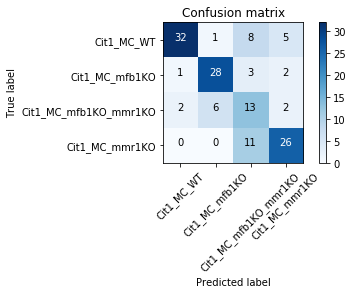

In [34]:
# analyze results 
log_preds, y = learn.TTA()
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

In [26]:
log_preds, y = learn.TTA()


In [60]:
idx = 70
print(log_preds[:,idx,:])
print(y[idx])

[[-0.97521 -5.20932 -0.74262 -1.95507]
 [-1.80745 -5.83305 -0.6632  -1.14634]
 [-2.30128 -7.388   -0.19952 -2.52411]
 [-0.95851 -6.02641 -0.83646 -1.70991]
 [-1.17304 -6.52456 -0.74665 -1.5364 ]]
2


In [31]:
log_preds_mean = np.mean(log_preds, axis=0)

In [32]:
log_preds_mean.shape

(140, 4)

In [18]:
log_preds.shape

(5, 140, 4)

In [20]:
preds.shape

(140,)

[[30  2  7  5]                               
 [ 0 28  5  2]
 [ 3  3 11  3]
 [ 2  2 12 25]]


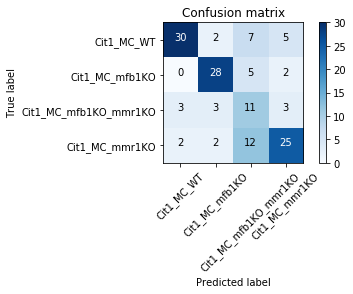

In [30]:
from sklearn.metrics import confusion_matrix
from resources.plots import *
import pickle
log_preds, y = learn.TTA()
preds = np.argmax(log_preds[1], axis=1)
cm = confusion_matrix(preds,y)
# with open('results/confusion_matrix.320.array','wb') as file:
#     pickle.dump(cm,file)
plot_confusion_matrix(cm, data.classes)

[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [35 35 35 35]]


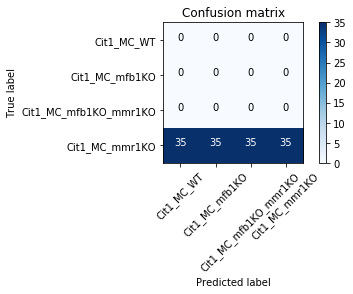

In [22]:
from sklearn.metrics import confusion_matrix
from resources.plots import *
import pickle
preds = np.argmax(log_preds[1], axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

In [ ]:
%time learn.fit(1e-1, 8, wds=wd, cycle_len=40, use_clr=(20,8, 0.95, 0.85))

In [24]:
learn.save('Objective_A_ResNets_per_class')

In [ ]:
log_preds, y = learn.TTA()

In [ ]:
y.shape

In [ ]:
log_preds[0].shape

In [ ]:
preds = np.argmax(log_preds[1],axis=1)
probs = np.exp(log_preds[:,1])

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)